### Summary
Ce projet a pour but de faire :
- dans un premier temps une classification supervisée sur la variable authorisation_status, qui definit si un médicament donné est autorisé à la vente ou non
- un modèle d'apprentissage non supervisé sur les différents groupes que la tâche précédente a permis de faire

### Analyse exploiratoire des données

In [66]:
#----------------------------Importation-des-modules-------------------------------------#
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import phik
import seaborn as sns
#------------for-the-model--------------------------------------------------------------#
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real, Integer
from skopt import BayesSearchCV

In [6]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-03-14/drugs.csv"
datas = pd.read_csv(url)

In [ ]:
datas.head()

In [ ]:
datas.describe()

#### Analyse univariée
1. Typologie des variables
- Variables quantitatives

In [10]:
numerical_columns = datas.select_dtypes(include=['number']).columns
print(numerical_columns)

Index(['product_number', 'revision_number'], dtype='object')


Les variables **product_number** et **revision_number** sont considérées comme quantitatives. Cependant avec une comprehension du dataset, ces variables sont plutot qualitatives même s'elles sont représentées par des nombres.

- Variables qualitatives

In [ ]:
numerical_columns = datas.select_dtypes(include=['object']).columns
print(numerical_columns)

Ainsi, nous pouvons considérer l' ensemble de notre dataset comme étant des variables qualitatives.

2. Valeurs manquantes dans les colonnes
- Décompte des valeurs manquantes

In [ ]:
datas.isnull().sum()

- Visualisation des données manquantes

In [ ]:
msno.bar(datas,
         filter="top",
         color="gray"
        );

**Pour les valeurs manquantes**, on voit qu'il y'a que quelques colonnes qui en ont. 
Cependant il y'a quatre (04) colonnes qui ont plus de valeurs manquantes que les autres. Ce sont les colonnes:
- **therapeutic_area**: avec 1703 valeurs renseignées sur 1988,
- **date_of_refusal_of_marketing_authorisation**: avec 75 valeurs renseignées sur 1988
- **date_of_opinion**: avec 1209 renseignees sur les 1988
- **species**: avec seulement 279 valeurs renseignées sur les 1988

3. Sélection de colonnes

- Résumé statistique des variables

In [ ]:
for col in datas.columns:
    if datas[col].dtype == 'object':  # Vérifiez si la colonne est catégorielle
        summary = datas[col].value_counts()
        print(f"Résumé de {col} :")
        print(summary)

- Visualisation du nombre modalités par variable

In [ ]:
datas.nunique()

Nous constatons que beaucoup de colonnes à variables qualitatives comportent plus de 1000 modalités sur les 1988. Ainsi en combinant, les colonnes à valeurs manquantes et certaines de ces colonnes, nous avons décidé de supprimer les colonnes et ainsi réduire la dimension de notre dataset.
Les colonnes à plus de 1000 categories qui ne sont pas supprimé sont:
- medecine_name: pour le nom du medicament
- active_substance: pour la substance active dans le medicament
- common_name: le nom courant du medicament

In [17]:
new_datas = datas.drop(['marketing_authorisation_date', 'product_number', 'decision_date', 'date_of_opinion', 'first_published', 'atc_code', 'condition_indication','product_number','url', 'revision_date','species', 'date_of_refusal_of_marketing_authorisation'], axis=1)

In [21]:
new_datas.shape

(1988, 17)

#### Exploration des variables
1. Variable cible: authorisation_status

In [23]:
target = datas['authorisation_status']

In [ ]:
sns.countplot(x=target, data=datas, palette="Set2", hue=target, legend=False)
plt.title("Distribution de la variable cible")

**Conclusion**: on voit que la variable cible a trois(03) categories: `autorised`, `withdrawn` et `refused`. Nous notons un certain desequilibre entre les differentes catégories

2. Distribution des autres variables

Vu le nombre de modalités sur les variables, nous allons faire des tableaux de frequence à la place des graphes de distribution

In [ ]:
colonnes_categorielles=new_datas.columns
for colonne in colonnes_categorielles:
    tableau = new_datas[colonne].value_counts().reset_index()
    tableau.columns = ['Catégorie', 'Fréquence']
    tableau['Pourcentage'] = (tableau['Fréquence'] / tableau['Fréquence'].sum()) * 100
    tableau_de_fréquence = tableau.sort_values(by='Fréquence', ascending=False)
    print(colonne+'\t')
    print("-------------------------------------")
    print(tableau_de_fréquence)
    print("-------------------------------------")

Ainsi , nous obtenu une vue sur les frequences de chaque modalité.

Nous allons maintenant voir la distribution des 2 modalités les plus représentées par classe

In [ ]:
for colonne in colonnes_categorielles:
    classe_count = new_datas[colonne].value_counts()

    top_2_classes = classe_count.head(2)

    subset_df = new_datas[new_datas[colonne].isin(top_2_classes.index)]

    tableau_croise = pd.crosstab(subset_df[colonne], subset_df[colonne])

    ax = tableau_croise.plot(kind='bar', stacked=True, figsize=(8, 6))

    ax.set_title(f'Distribution des 2 classes les plus représentées ({colonne})')
    ax.set_ylabel('Nombre d\'occurrences')

    plt.show()

**Conclusion**
Nous constatons un certain nombre de desiquilibre en les modalités de certaines variables:
- orphan_medicine: nous voyons que la portion de medicament développée pour maladie grave et rare est nettement supérieure à celle des medicaments ordinaires
- accelerated_assessment: la portion de médicament pour la santé publique est très minime par rapport à ceux qui ne le sont pas. exceptional_circumtances, conditional_approval, biosimilar suivent la même distribution

#### Analyse bi-variée

Pour materialier, l'analye bi-variée entre nos variables categorielles et nos variables cibles, nous utliserons les tableaux de contingence.

In [ ]:
variable_cible = 'authorisation_status'

# Liste des autres variables catégorielles
variables_catégorielles = [col for col in new_datas.columns if col != variable_cible]

# Créer un dictionnaire pour stocker les tableaux de contingence
tableaux_contingence = {}

# Parcourir chaque variable catégorielle et créer un tableau de contingence
for variable in variables_catégorielles:
    tableau_croise = pd.crosstab(index=new_datas[variable], columns=new_datas[variable_cible])
    tableaux_contingence[variable] = tableau_croise

# Afficher les tableaux de contingence
for variable, tableau in tableaux_contingence.items():
    print(f"Tableau de contingence pour {variable} :\n{tableau}\n")
    print("-------------------------------------------------------")

Les graphes pour chaque variable et la variable cible à partir des tableaux de contingence.

In [ ]:
for variable, tableau in tableaux_contingence.items():
    tableau.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Relation entre {variable} et {variable_cible}')
    plt.xlabel(variable)
    plt.ylabel('Nombre d\'occurrences')
    plt.legend(title=variable_cible)

    plt.show()

**Interprétation des graphes**:

Matrice de correlation entre les différentes variables en utilisant le PHI.
Pour ce faire, nous allons enlever les variables :


*   active_substance
*   common_name
*   medicine_name
qui comporte pres de 1000 modalités mais que nous avions décidé de garder

In [ ]:
Phi_corr = new_datas.drop(['active_substance','common_name', 'medicine_name'], axis=1).phik_matrix()

mask = np.zeros_like(Phi_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(20,17))
  plot = sns.heatmap(Phi_corr, mask=mask, annot=True, fmt='.1f',linewidths=.5, ax=ax,cmap='coolwarm',robust=True, square=True,cbar=False) #annot=True writes data in rect boxes
  plt.title('Correlation des variables ',size = 15)
  plt.show()

Nous voyons que notre variable cible a peu de valeurs avec lesquelles elle est corrélées suivant le coefficient de Phi. Du coup, on va eesayer encore plus lors de la prédiction d'utiliser des modèles complexes pour detecter les relations complexes ou encore faire un renforcement des données pour mieux faire la prediction de cette variable

### Analyse supervisée

In [ ]:
null_values_in_column = datas[datas["authorisation_status"].isna()]
datas.drop(index=1528, axis=0, inplace=True)

- Separation de la variable cible et des variables explicatives

In [42]:
X = datas.drop(["authorisation_status"], axis=1)
y = datas["authorisation_status"]

- Visualisation de la distribution de la variable cible

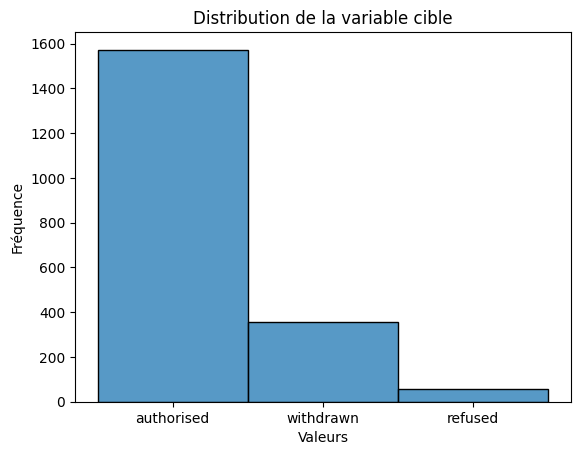

In [43]:
sns.histplot(y)
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Distribution de la variable cible')
plt.show()

- Encodage des variables categorielles

In [44]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
encoder = LabelEncoder()

for categ in categorical_columns:
    dict_col=encoder.fit(X[categ])  
    X[categ] = encoder.transform(X[categ])
    
encoder_2 = OneHotEncoder()
encoder_2.fit(X)

OneHotEncoder()

- Suppression des colonnes avec des valeurs nulles 

In [45]:
X.drop(columns="revision_number", axis=1, inplace=True)

- Standardisation des variables explicatives 

Vu que notre dataset contient principalement que des variables categorielles, nous allons les standardiser.

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Splitting des donnees en train et test 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.3)

Nous voyons que notre variable cible est tres inegalement distribue entre les classes. Pour mettre en place nos modeles, nous allons dans un premeir temps les entrainer avec le "desequilibre de classe" avant d'appliquer la technique de "sampling" puis les entrainer de nouveau. A la fin nous ferons une comparaison des modeles dans les deux cas.

#### Entrainement avec les donnees "unbalanced" de la classe cible

Dans un premier temps, nous allons faire l'entrainement de nos modèles sur les données en conservant le déséquilibre de classes sur la variable cible et voir les résultats.

1. **Régression Logistique**

In [48]:
model_rl= LogisticRegression(C=0.1, penalty='l2', max_iter=1000, multi_class='ovr')
model_rl.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr')

In [49]:
y_pred = model_rl.predict(X_test)
# Évaluez la performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("The accuracy is {}".format(accuracy))
print(report)

The accuracy is 0.9463986599664992
              precision    recall  f1-score   support

  authorised       0.96      0.98      0.97       478
     refused       1.00      0.65      0.79        17
   withdrawn       0.89      0.83      0.86       102

    accuracy                           0.95       597
   macro avg       0.95      0.82      0.87       597
weighted avg       0.95      0.95      0.94       597



Nous voyons que notre modele est en surapprentissage en se basant sur les resultats de `f1-score`,`recall` et `precision`. En effet les metriques sont nulles pour les classes minoritaires `refused` et `withdrawn`.

- Optimisation des hyperparametres du modèle: nous allons faire l'optimisation des hyperparametres pour améliorer les performances du modèle.

In [50]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': [100, 200, 300]
}
random_search = RandomizedSearchCV(model_rl, param_distributions=param_grid, n_iter=10, scoring='f1_micro', cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(C=0.1, max_iter=1000,
                                                multi_class='ovr'),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l2']},
                   scoring='f1_micro')

In [51]:
best_params = random_search.best_params_

In [ ]:
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)

In [53]:
y_pred = best_model.predict(X_test)
# Évaluez la performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  authorised       0.97      0.99      0.98       478
     refused       1.00      0.76      0.87        17
   withdrawn       0.91      0.88      0.90       102

    accuracy                           0.96       597
   macro avg       0.96      0.88      0.91       597
weighted avg       0.96      0.96      0.96       597



Malgre, l'optimisation nous voyons clairement que les metriques sont nulles pour les classes minoritaires `refused` et `withdrawn`. Nous allons utiliser la matrice de confusion pour mieux visualiser les resultats.
- Matrice de confusion

In [ ]:
confusion = confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion (en tant que tableau)
print("Matrice de Confusion :\n", confusion)
# Visualisation de la répartition des classes prédites vs réelles
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()
classes = np.unique(y.values)
tick_marks = np.arange(len(classes))
print(classes)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.tight_layout()
plt.show()

Toutes les predictions sont faites sur la classe majoritaire pour ce modèle.

2. **RandomForestModel**

In [56]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [57]:
y_pred = model_rf.predict(X_test)
# Évaluez la performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("The accuracy is {}".format(accuracy))
print(report)

The accuracy is 0.9631490787269682
              precision    recall  f1-score   support

  authorised       0.97      0.99      0.98       478
     refused       1.00      1.00      1.00        17
   withdrawn       0.93      0.84      0.89       102

    accuracy                           0.96       597
   macro avg       0.97      0.94      0.95       597
weighted avg       0.96      0.96      0.96       597



Les résultats sont légèrement meilleurs que ceux obtenus avec la Regression Logistique. Le `rappel`, la `precision` et la `f1` score par classe sont meilleurs que ceux obtenus avec la Regression Logistique.

- Optimisation du modèle

In [58]:
param_dist = {
    'n_estimators': range(10,100,10),  # Nombre d'arbres
    'max_depth': [1, 10, 20, 30, 40,50]  # Profondeur maximale
}

In [59]:
random_search = RandomizedSearchCV(model_rf, param_distributions=param_dist, n_iter=10, scoring='f1_micro', cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [1, 10, 20, 30, 40, 50],
                                        'n_estimators': range(10, 100, 10)},
                   scoring='f1_micro')

In [60]:
best_params_rf = random_search.best_params_
best_model = RandomForestClassifier(**best_params_rf)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=40)

In [61]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  authorised       0.97      0.99      0.98       478
     refused       1.00      1.00      1.00        17
   withdrawn       0.93      0.83      0.88       102

    accuracy                           0.96       597
   macro avg       0.97      0.94      0.95       597
weighted avg       0.96      0.96      0.96       597



In [ ]:
confusion = confusion_matrix(y_test, y_pred)

# Visualisation de la répartition des classes prédites vs réelles
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()

classes = np.unique(y.values)
tick_marks = np.arange(len(classes))
print(tick_marks)
print(classes)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.tight_layout()
plt.show()

Le poids de la classe majoritaire fait toujours que les resultats obtenus sont biaises.

3. **XGBoost**

Encodage de la variable cible

In [63]:
encoder = OneHotEncoder(sparse=False)
one_ytrain_encoded= encoder.fit_transform(y_train.values.reshape(-1,1))
one_ytest_encoded = encoder.fit_transform(y_test.values.reshape(-1,1))

/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


- Entrainement

In [64]:
model_xgb = XGBClassifier(n_estimators=100, max_depth=20)
model_xgb.fit(X_train, one_ytrain_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [65]:
y_pred = model_xgb.predict(X_test)
report = classification_report(one_ytest_encoded, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       478
           1       1.00      1.00      1.00        17
           2       0.96      0.86      0.91       102

   micro avg       0.97      0.97      0.97       597
   macro avg       0.97      0.95      0.96       597
weighted avg       0.97      0.97      0.97       597
 samples avg       0.96      0.97      0.97       597



/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Par rapport au `f1-score`, on observe une legere amelioeration comparee au modele RandomForest sur les classes minoritaires

- Optimisation du modèle

In [67]:
param_space = {
    'n_estimators': Integer(100, 1000),  # Nombre d'arbres
    'max_depth': Integer(3, 10),  # Profondeur maximale
    'learning_rate': Real(0.01, 0.3),  # Taux d'apprentissage
    'subsample': Real(0.5, 1.0),  # Fraction d'échantillons utilisés pour l'apprentissage de chaque arbre
    'colsample_bytree': Real(0.5, 1.0),  # Fraction de colonnes utilisées pour l'apprentissage de chaque arbre
    'gamma': Real(0, 1.0)  # Paramètre de régularisation
}

In [71]:
bayes_search = BayesSearchCV(model_xgb, param_space, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)